# Ridge and Lasso Regression

Ridge and Lasso regression are powerful techniques generally used in the presence of a large number of features. Large, here, can mean one of two things:
1. Large enough to enhance the *tendency of a model to overfit* (as low as 10 variables may cause overfitting)
2. Large enough to *cause computational challenges*. In modern sytems, this situation might arise in the case of millions or billions of features.

Though Ridge and Lasso might appear to work towards a common goal, the inherent properties and pratical use cases differ substantially. They generally work by penalizing the magnitude of coefficients of features along with minimizing the error between predicted and actual observations. The key difference is how they assign penalties to the coefficients:
1. **Ridge Regression:**
    * Performs L2 regularization, i.e. adds penalty equivalent to the **square of the magnitude** of coefficients
    * Minimization objective = LS Obj + a $\times$ (sum of square of coefficients)
2. **Lasso Regression:**
    * Performs L1 regularization, i.e. adds penalty equivalent to the **absolute value of magnitude** pf coefficients
    * Minimization objective = Ls Obj + a $\times$ (sum of absolute value of coefficients)
    
*Note* - "LS Obj" refers to the "least squares objective", i.e. the linear regression objective without regularization.

#

As an example, I'm going to create random data in the shape of a sine curve with random noise.

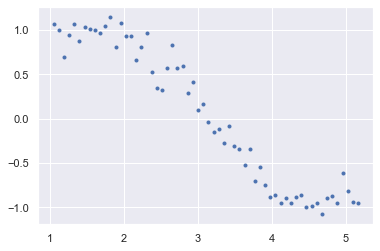

In [3]:
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set()

np.random.seed(10)

# input array with angles from 60deg to 300deg converted to radians
x = np.array([i * np.pi/180 for i in range(60,300,4)])

y = np.sin(x) + np.random.normal(0, 0.15, len(x))

data = pd.DataFrame(np.column_stack([x, y]), columns=['x', 'y'])

plt.plot(data['x'], data['y'], '.')

We'll try to estimate the sine function using **polynomial regression** with powers of x from 1 to 15. To do this, I'm going to add a column for each power up to 15 in our dataframe:

In [6]:
for i in range(2, 16): # power of 1 already exists
    colname = f"x_{i}"
    data[colname] = data['x'] ** i
    
data.head()

,x,y,x_2,x_3,x_4,x_5,x_6,x_7,x_8,x_9,x_10,x_11,x_12,x_13,x_14,x_15
0,1.047198,1.065763,1.096623,1.148381,1.202581,1.259340,1.318778,1.381021,1.446202,1.514459,1.585938,1.660790,1.739176,1.821260,1.907219,1.997235
1,1.117011,1.006086,1.247713,1.393709,1.556788,1.738948,1.942424,2.169709,2.423588,2.707173,3.023942,3.377775,3.773011,4.214494,4.707635,5.258479
2,1.186824,0.695374,1.408551,1.671702,1.984016,2.354677,2.794587,3.316683,3.936319,4.671717,5.544505,6.580351,7.809718,9.268760,11.000386,13.055521
3,1.256637,0.949799,1.579137,1.984402,2.493673,3.133642,3.937850,4.948448,6.218404,7.814277,9.819710,12.339811,15.506664,19.486248,24.487142,30.771450
4,1.326450,1.063496,1.759470,2.333850,3.095735,4.106339,5.446854,7.224981,9.583578,12.712139,16.862020,22.366630,29.668222,39.353420,52.200353,69.241170


Now, we'll create 15 different linear regression models, each model containing variables with powers of x from 1 to the particular model number (model 8 will have {x, x_2,..., x_8}.

First, we'll define a function that takes in the required maximum power of x as an input and returns a list containing `[model RSS, intercept, coef_x, coef_x2,..., coef_x15]`. RSS = Residual Sum of Squares, the sum of squared errors between the predicted and actual values in the training set:

In [12]:
# import Linear Regression model from scikit-learn.
from sklearn.linear_model import LinearRegression
def linear_regression(data, power, models_to_plot):
    #initialize predictors:
    predictors=['x']
    if power>=2:
        predictors.extend([f"x_{i}" for i in range(2, power+1)])
    
    # fit the model
    linreg = LinearRegression(normalize=True)
    linreg.fit(data[predictors],data['y'])
    y_pred = linreg.predict(data[predictors])
    
    # check if a plot is to be made for the entered power
    if power in models_to_plot:
        plt.subplot(models_to_plot[power])
        plt.tight_layout()
        plt.plot(data['x'],y_pred)
        plt.plot(data['x'],data['y'],'.')
        plt.title(f"Plot for power: {power}")
    
    # return the result in pre-defined format
    rss = sum((y_pred-data['y'])**2)
    ret = [rss]
    ret.extend([linreg.intercept_])
    ret.extend(linreg.coef_)
    return ret

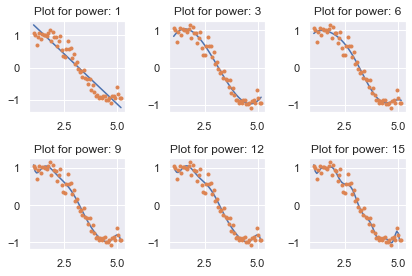

In [11]:
# Create the models, store results and plot 6 of them

# Initialize the dataframe to store results
col = ['rss', 'intercept'] + [f"coef_x_{i}" for i in range(1, 16)]
ind = [f"model_pow_{i}" for i in range(1, 16)]
coef_matrix_simple = pd.DataFrame(index=ind, columns=col)

# define the powers for which a plot is required
models_to_plot = {1:231, 3:232, 6:233, 9:234, 12:235, 15:236}

# iterate through all of the powers and assimilate results
for i in range(1, 16):
    coef_matrix_simple.iloc[i-1, 0:i+2] = linear_regression(data, power=i, models_to_plot=models_to_plot)

This clearly shows that **as model complexity increases, the models tend to fit even smaller deviations in the training data set**, i.e. it overfits.

This can be analyzed via the dataframe below:

In [15]:
# set display format to scientific
pd.options.display.float_format = '{:,.2g}'.format

coef_matrix_simple

,rss,intercept,coef_x_1,coef_x_2,coef_x_3,coef_x_4,coef_x_5,coef_x_6,coef_x_7,coef_x_8,coef_x_9,coef_x_10,coef_x_11,coef_x_12,coef_x_13,coef_x_14,coef_x_15
model_pow_1,3.3,2,-0.62,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
model_pow_2,3.3,1.9,-0.58,-0.006,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
model_pow_3,1.1,-1.1,3,-1.3,0.14,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
model_pow_4,1.1,-0.27,1.7,-0.53,-0.036,0.014,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
model_pow_5,1,3,-5.1,4.7,-1.9,0.33,-0.021,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
model_pow_6,0.99,-2.8,9.5,-9.7,5.2,-1.6,0.23,-0.014,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
model_pow_7,0.93,19,-56,69,-45,17,-3.5,0.4,-0.019,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
model_pow_8,0.92,43,-1.4e+02,1.8e+02,-1.3e+02,58,-15,2.4,-0.21,0.0077,NaN,NaN,NaN,NaN,NaN,NaN,NaN
model_pow_9,0.87,1.7e+02,-6.1e+02,9.6e+02,-8.5e+02,4.6e+02,-1.6e+02,37,-5.2,0.42,-0.015,NaN,NaN,NaN,NaN,NaN,NaN
model_pow_10,0.87,1.4e+02,-4.9e+02,7.3e+02,-6e+02,2.9e+02,-87,15,-0.81,-0.14,0.026,-0.0013,NaN,NaN,NaN,NaN,NaN


This shows that the **size of coefficients increase exponentially with an increase in model complexity**. What does this signify?

It means that we're putting a lot of emphasis on that feature, i.e. the particular feature is a good predictor for the outcome. When it becomes *too* large, the algorithm starts modelling interesting relations to estimate the output and ends up overfitting to the particular training data.

# Ridge Regression
As mentioned before, Ridge Regression performs **L2 Regularization**, i.e. it adds a factor of sum of squares coefficients in the optimization objective, resulting in the following:
#### Objective = RSS + $\alpha$ * (sum of squared coefficients)
Here, $\alpha$ is the hyperparameter which balances the amount of emphasis given to minimizing RSS vs. minimizing the sum of squared coefficients. It can take values:
* $a = 0$
    * The objective becomes the same as simple linear regression
    * Gives us the same coefficients as simple linear regression
* $a = \infty$
    * The coefficients will be zero. Why? Because of infinate weightage on the square of coefficients, anything less than zero will make the objective infinite
* $0 \lt a \lt \infty$
    * The magnitude of $a$ will decide the weightage given to different parts of the objective
    * The coefficients will be somewhere between 0 and ones for simple linear regression

Time to code out a generic function for ridge regression, similar to the one defined for simple linear regression.

In [16]:
from sklearn.linear_model import Ridge

def ridge_regression(data, predictors, alpha, models_to_plot={}):
    # fit the model
    ridgereg = Ridge(alpha=alpha, normalize=True)
    ridgereg.fit(data[predictors], data['y'])
    y_pred = ridgereg.predict(data[predictors])
    
    # check if a plot is to be made for the entered alpha
    if alpha in models_to_plot:
        plt.subplot(models_to_plot[alpha])
        plt.tight_layout()
        plt.plot(data['x'], y_pred)
        plt.plot(data['x'], data['y'], '.')
        plt.title(f"Plot for alpha: {alpha}")
        
    # return the result in pre-defined format
    rss = sum((y_pred - data['y']) ** 2)
    ret = [rss]
    ret.extend([ridgereg.intercept_])
    ret.extend(ridgereg.coef_)
    return ret

Now we'll analyze the result of Ridge Regression for 10 different values of $a$ ranging from 1e-15 to 20 (these were chosen at random to display the effects of changing $a$)

*Note* each of these 10 models contain all 15 variables and only the value of $a$ differs. This is different from the simple linear regression case where each model had a subset of the features.

C:\Users\jfields\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=3.46852e-17): result may not be accurate.
  overwrite_a=True).T


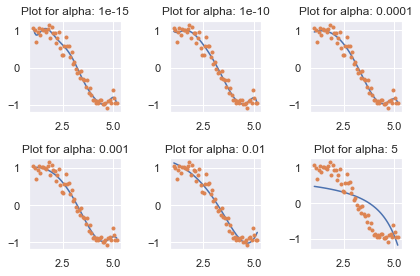

In [22]:
# initialize predictors to be the set of 15 powers of x
predictors = ['x']
predictors.extend([f"x_{i}" for i in range(2, 16)])

# set the different values of alpha to be tested
alpha_ridge = [1e-15, 1e-10, 1e-8, 1e-4, 1e-3,1e-2, 1, 5, 10, 20]

# initialize the datframe for storing coefficients
col = ['rss', 'intercept'] + [f"coef_x_{i}" for i in range(1, 16)]
ind = [f"alpha_{alpha_ridge[i]}" for i in range(0, 10)]
coef_matrix_ridge = pd.DataFrame(index=ind, columns=col)

models_to_plot = {1e-15:231, 1e-10:232, 1e-4:233, 1e-3:234, 1e-2:235, 5:236}
for i in range(10):
    coef_matrix_ridge.iloc[i,] = ridge_regression(data, predictors, alpha_ridge[i], models_to_plot)

Here we can clearly observe that **as the value of alpha increases, the model complexity reduces**. Though higher value of $\alpha$ reduce overfitting, significantly high values can cause underfitting as well (eg. alpha = 5). Thus, **choose alpha wisely!**. A widely accepted technique is cross-validation, i.e. the value of alpha is iterated over a range of values and the one giving the highest cross-validation score is chosen.

Let's look at the coefficients in the above model:

In [23]:
# set the display format to be scientific for ease of analysis
pd.options.display.float_format = '{:,.2g}'.format

coef_matrix_ridge

,rss,intercept,coef_x_1,coef_x_2,coef_x_3,coef_x_4,coef_x_5,coef_x_6,coef_x_7,coef_x_8,coef_x_9,coef_x_10,coef_x_11,coef_x_12,coef_x_13,coef_x_14,coef_x_15
alpha_1e-15,0.87,94,-3e+02,3.8e+02,-2.3e+02,65,0.54,-4.3,0.39,0.2,-0.028,-0.007,0.0012,0.00019,-5.6e-05,4.1e-06,-7.8e-08
alpha_1e-10,0.92,11,-29,31,-15,2.9,0.17,-0.091,-0.011,0.002,0.00064,2.4e-05,-2e-05,-4.2e-06,2.2e-07,2.3e-07,-2.3e-08
alpha_1e-08,0.95,1.3,-1.5,1.7,-0.68,0.039,0.016,0.00016,-0.00036,-5.4e-05,-2.9e-07,1.1e-06,1.9e-07,2e-08,3.9e-09,8.2e-10,-4.6e-10
alpha_0.0001,0.96,0.56,0.55,-0.13,-0.026,-0.0028,-0.00011,4.1e-05,1.5e-05,3.7e-06,7.4e-07,1.3e-07,1.9e-08,1.9e-09,-1.3e-10,-1.5e-10,-6.2e-11
alpha_0.001,1,0.82,0.31,-0.087,-0.02,-0.0028,-0.00022,1.8e-05,1.2e-05,3.4e-06,7.3e-07,1.3e-07,1.9e-08,1.7e-09,-1.5e-10,-1.4e-10,-5.2e-11
alpha_0.01,1.4,1.3,-0.088,-0.052,-0.01,-0.0014,-0.00013,7.2e-07,4.1e-06,1.3e-06,3e-07,5.6e-08,9e-09,1.1e-09,4.3e-11,-3.1e-11,-1.5e-11
alpha_1,5.6,0.97,-0.14,-0.019,-0.003,-0.00047,-7e-05,-9.9e-06,-1.3e-06,-1.4e-07,-9.3e-09,1.3e-09,7.8e-10,2.4e-10,6.2e-11,1.4e-11,3.2e-12
alpha_5,14,0.55,-0.059,-0.0085,-0.0014,-0.00024,-4.1e-05,-6.9e-06,-1.1e-06,-1.9e-07,-3.1e-08,-5.1e-09,-8.2e-10,-1.3e-10,-2e-11,-3e-12,-4.2e-13
alpha_10,18,0.4,-0.037,-0.0055,-0.00095,-0.00017,-3e-05,-5.2e-06,-9.2e-07,-1.6e-07,-2.9e-08,-5.1e-09,-9.1e-10,-1.6e-10,-2.9e-11,-5.1e-12,-9.1e-13
alpha_20,23,0.28,-0.022,-0.0034,-0.0006,-0.00011,-2e-05,-3.6e-06,-6.6e-07,-1.2e-07,-2.2e-08,-4e-09,-7.5e-10,-1.4e-10,-2.5e-11,-4.7e-12,-8.7e-13


What we see here:
1. The RSS increases with the increase in alpha, this model complexity reduces
2. An $\alpha$ as small as 1e-15 gives us significant reduction in the magnitude of coefficients. How? Compare the coefficients in the first row of this table to the last row of the simple linear regression table.
3. High alpha values can lead to significant underfitting. Note the rapid increase in RSS for values of alpha greater than 1
4. Though the coefficients are **very very small**, they are **not zero** (shown below)

In [24]:
coef_matrix_ridge.apply(lambda x: sum(x.values==0), axis=1)

alpha_1e-15     0
alpha_1e-10     0
alpha_1e-08     0
alpha_0.0001    0
alpha_0.001     0
alpha_0.01      0
alpha_1         0
alpha_5         0
alpha_10        0
alpha_20        0
dtype: int64

This confirms that all 15 coefficients are greater than zero in magnitude. This will play an important role later while comparing ridge with lasso regression.

# Lasso Regression
LASSO stands for *Least Absolute Shrinkage and Selection Operator*. Key words: absolute and selection.

Lasso Regression performs **L1 Regularization**, i.e. it adds a factor of the sum of absolute values of coefficients in the optimization objective, optimizing the following:
#### Objective = RSS + $\alpha$ * (sum of the absolute value of coefficients)
Here, $\alpha$ works similar to that of ridge and provides a trade-off between balancing RSS and the magnitude of coefficients. It can take values:
* $a = 0$: Same coefficients as simple linear regression
* $a = \infty$: All coefficients zero (same logic as before)
* $0 < \alpha < \infty$: Coefficients between 0 and that of simple linear regression

Let's define the function:

In [26]:
from sklearn.linear_model import Lasso

def lasso_regression(data, predictors, alpha, models_to_plot={}):
    # fit the model
    lassoreg = Lasso(alpha=alpha, normalize=True, max_iter=1e5)
    lassoreg.fit(data[predictors], data['y'])
    y_pred = lassoreg.predict(data[predictors])
    
    # check if a plot is to be made for the entered alpha
    if alpha in models_to_plot:
        plt.subplot(models_to_plot[alpha])
        plt.tight_layout()
        plt.plot(data['x'], y_pred)
        plt.plot(data['x'], data['y'], '.')
        plt.title(f"Plot for alpha: {alpha}")
    
    # return the result in pre-defined format
    rss = sum((y_pred - data['y'])**2)
    ret = [rss]
    ret.extend([lassoreg.intercept_])
    ret.extend(lassoreg.coef_)
    return ret

Notice the additional parameter `max_iter` - this is the maximum number of iterations for which we want the model to run if it doesn't converge before. This exists for Ridge as well but setting this to a higher value than default was required for the sake of our example.

Let's check the output for 10 different values of alpha using the following code:

C:\Users\jfields\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.47835738259043836, tolerance: 0.003694803842184409
  positive)
C:\Users\jfields\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.47828183990577433, tolerance: 0.003694803842184409
  positive)
C:\Users\jfields\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.470793301904076, tolerance: 0.003694803842184409
  positive)


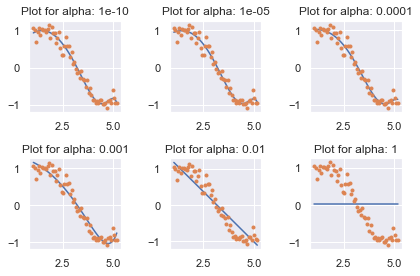

In [29]:
# initialize predictors to all 15 powers of x
predictors = ['x']
predictors.extend([f"x_{i}" for i in range(2, 16)])

# define the alpha values to test
alpha_lasso = [1e-15, 1e-10, 1e-8, 1e-5,1e-4, 1e-3,1e-2, 1, 5, 10]

# initialize the dataframe to store coefficients
col = ['rss', 'intercept'] + [f"coef_x_{i}" for i in range(1, 16)]
ind = [f"alpha_{alpha_lasso[i]}" for i in range(0, 10)]
coef_matrix_lasso = pd.DataFrame(index=ind, columns=col)

# define the models to plot
models_to_plot = {1e-10:231, 1e-5:232,1e-4:233, 1e-3:234, 1e-2:235, 1:236}

# iterate over the 10 alpha values
for i in range(10):
    coef_matrix_lasso.iloc[i, ] = lasso_regression(data, predictors, alpha_lasso[i], models_to_plot)

Again, we see that the model complexity decreases with an increase in the value of $alpha$. But notice the straight line at alpha=1. Lets look at the coefficients:

In [31]:
coef_matrix_lasso

,rss,intercept,coef_x_1,coef_x_2,coef_x_3,coef_x_4,coef_x_5,coef_x_6,coef_x_7,coef_x_8,coef_x_9,coef_x_10,coef_x_11,coef_x_12,coef_x_13,coef_x_14,coef_x_15
alpha_1e-15,0.96,0.22,1.1,-0.37,0.00089,0.0016,-0.00012,-6.4e-05,-6.3e-06,1.4e-06,7.8e-07,2.1e-07,4e-08,5.4e-09,1.8e-10,-2e-10,-9.2e-11
alpha_1e-10,0.96,0.22,1.1,-0.37,0.00088,0.0016,-0.00012,-6.4e-05,-6.3e-06,1.4e-06,7.8e-07,2.1e-07,4e-08,5.4e-09,1.8e-10,-2e-10,-9.2e-11
alpha_1e-08,0.96,0.22,1.1,-0.37,0.00077,0.0016,-0.00011,-6.4e-05,-6.3e-06,1.4e-06,7.8e-07,2.1e-07,4e-08,5.3e-09,2e-10,-1.9e-10,-9.3e-11
alpha_1e-05,0.96,0.5,0.6,-0.13,-0.038,-0,0,0,0,7.7e-06,1e-06,7.7e-08,0,0,0,-0,-7e-11
alpha_0.0001,1,0.9,0.17,-0,-0.048,-0,-0,0,0,9.5e-06,5.1e-07,0,0,0,-0,-0,-4.4e-11
alpha_0.001,1.7,1.3,-0,-0.13,-0,-0,-0,0,0,0,0,0,1.5e-08,7.5e-10,0,0,0
alpha_0.01,3.6,1.8,-0.55,-0.00056,-0,-0,-0,-0,-0,-0,-0,0,0,0,0,0,0
alpha_1,37,0.038,-0,-0,-0,-0,-0,-0,-0,-0,-0,-0,-0,-0,-0,-0,-0
alpha_5,37,0.038,-0,-0,-0,-0,-0,-0,-0,-0,-0,-0,-0,-0,-0,-0,-0
alpha_10,37,0.038,-0,-0,-0,-0,-0,-0,-0,-0,-0,-0,-0,-0,-0,-0,-0


What's going on here?
1. For the same values of $\alpha$, the coefficients of lasso regression are much smaller as compared to that of ridge regression (compare row 1 of the 2 tables)
2. For the same $\alpha$, lasso has a higher RSS (poorer fit) as compared to ridge regression
3. Many of the coefficients are zero, even for very small values of alpha

Number 1. and 2. may not generalize but they're common. The real difference from ridge comes out in the last inference. Look at the number of coefficients which are zero in each model:

In [32]:
coef_matrix_lasso.apply(lambda x: sum(x.values==0), axis=1)

alpha_1e-15      0
alpha_1e-10      0
alpha_1e-08      0
alpha_1e-05      8
alpha_0.0001    10
alpha_0.001     12
alpha_0.01      13
alpha_1         15
alpha_5         15
alpha_10        15
dtype: int64

**Even for a small value of $\alpha$, a significant number of coefficients are zero$**. This explains the horizontal line fit for alpha=1 in the lasso plots - its just a baseline model! This phenomenon of most of the coefficients being zero is called **sparsity**. Although lasso performs feature selection, this level of sparsity is achieved in special cases. Let's take a bird's eye view of the math behind why coefficients are zero in the case of lasso, and not ridge regression.

# Maths
The basic structure of data in a regression problem is:

![regression](https://www.analyticsvidhya.com/wp-content/uploads/2016/01/fig31-1024x838.png)

Where:
* **$X$:** is the matrix of input features with nrow: N, ncol: M+1
* **$Y$:** the actual outcome variable with length: N
* **$Yhat$:** the predicted values of Y with length: N
* **$W$:** the weights of the coefficients with length: M+1

Here, N is the total number of data points available and M is the total number of features. X has M+1 columns because of M features and 1 intercept

The predicted value for any data point is:

$$
\hat{y}_i - \sum_{j=0}^{M} w_j \times x_{ij}
$$

It's simply the weighted sum of each data point with coefficients as the weights. This prediction is achieved by finding the optimum value of weights based on certain criteria, which depends on the type of regression algorithm being used. Let's consider 3 cases:

## 1. Simple Linear Regression
The objective (cost) function to be minimized is just the RSS (Residual Sum of Squares), i.e. the sum of squared errors of the predicted outcome as compared to the actual outcome. This can be depicted as:
$$
Cost(W) = RSS(W) = \sum_{i=1}^{N} {y_i - \hat{y}_i}^2 = \sum_{i=1}^{N}\bigg[ y_i - \sum_{j=0}^{M} w_j x_ij \bigg]
$$

In order to minimize this cost, we generally use a gradient descent algorithm which essentially:
1. initialize weights (say $w=0$)
2. iterate till not converged
    1. determine the gradient
    2. update the $j_{th}$ weight by subtracting learning rate times the gradient 
        * $w(t+1) = w(t)$ - learning rate * gradient
        
The most important step is 2.1 where we compute the gradient. The gradient is nothing but a partial differential of the cost with respect to a particular weight (denoted as $w_j$). The gradient for the $j^{th}$ weight would be:
$$
\frac{\delta}{\delta w_j} Cost(W) = -2 \sum_{i=1}^{N} x_ij \bigg[ y_i - \sum_{k=0}^{M} w_k x_{ik} \bigg]
$$

This is formed in 2 parts:
1. $2 * {...}$: This is formed because we've differentiated the square of the term in ${...}$
2. $-w_j$: This is the differentiation of the part in ${...}$ wrt $w_j$. Since its a summation, all other weights would become 0 and only $w_j$ would remain.

Step 2.2 involves updating the weights using the gradient. This update step for simple linear regression looks like:
$$
w_{j}^{t+1} = w_{j}^{t} -2n \sum_{i=1}^{N} x_ij \bigg[ y_i - \sum_{k=0}^{M} w_k x_{ik} \bigg]
$$

Convergence regers to attaining the optimum solution within a pre-defined limit. It is checked using the value of the gradient. If the gradient is small enough, that means we are very close to optimum and further iterations won't have a significant impact of the coefficients. The lower limit of the gradient can be changed using the `tol` parameter

## 2. Ridge Regression
The objective (cost) function to be minimized is the RSS plus the sum of square of the magnitude of weights. It looks like:
$$
Cost (W) = RSS(W) = \lambda * (sum\space of\space squares\space of\space weights) = \sum_{i=1}^{N}\bigg[y_i - \sum_{j=0}^{M} w_j x_{ij}\bigg]^2 + \lambda \sum_{j=0}^{M} w_j^2
$$

In this case, the gradient would be:
$$
\frac{\delta}{\delta w_j} Cost(W) = -2 \sum_{i=1}^{N} x_ij \bigg[ y_i - \sum_{k=0}^{M} w_k x_{ik} \bigg] + 2\lambda w_j
$$

Again, in the regularization part of the gradient only $w_j$ remains and the other weights become zero. The corresponding update rule is:
$$
w_j^{t+1} = w_j^t - n\Bigg[ -2 \sum_{i=1}^{N} x_ij \bigg[ y_i - \sum_{k=0}^{M} w_k x_{ik} \bigg] + 2\lambda w_j \Bigg]
$$
$$
w_j^{t+1} = (1 - 2\lambda n)w_j^t + 2n \sum_{i=1}^{N} x_ij \bigg[ y_i - \sum_{k=0}^{M} w_k x_{ik} \bigg]
$$

Here, we can see that the second part of RHS is the same as simple linear regression. Thus, ridge regression is equivalent to reducing the weight by a factor of $(1-2\lambda n)$ first and then applying the same update rule as simple linear regression. This is why the coefficients get reduced to small numbers but never become zero.

The criteria for convergence in this case remains similar to simple linear regression, i.e. checking the value of the gradients.

## 3. Lasso Regression
The objective (cost) function to be minimized is the RSS plus the sum of absolute values of the magnitude of the weights:
$$
Cost (W) = RSS(W) + \lambda \ times (sum\space of\space absolute\space value\space of\space weights\space) = \sum_{i=1}^{N} \bigg[ y_i - \sum_{j=0}^{M} w_j x_{ij} \bigg]^2 + \lambda \sum_{j=0}^{M} |{w_j}|
$$

In this case, the gradient is not defined as the absolute function is not differentiable at x=0. This can be illustrated as
![no zero grad](https://www.analyticsvidhya.com/wp-content/uploads/2016/01/fig1.png)
Here, we can see that the parts on the left and right side of zero are straight lines with defined derivatives but the function cannot be differentiated at x=0. In this case, we have to use a different technique called **coordinate descent** which is based on the concept of sub-gradients, which follows these steps:
1. initialize the weights, say $w=0$
2. iterate till not converged
    1. iterate over all features ${j=0, 1....M}$
        1. update the $j_{th}$ weight with a value which minimizes the cost
        
2.1.1 is sorta generalized, but the update rule is:
* if $g(w_{-j}) \lt -\frac{\delta}{2}$
    * **$w_j = g(w_{-j}) +\frac{\delta}{2}$**
* if $-\frac{\delta}{2} \leq g(w_{-j}) \leq \frac{\delta}{2} $
    * **$w_j = 0$**
* if $g(w_{-j}) \gt -\frac{\delta}{2}$
    * **$w_j = g(w_{-j}) -\frac{\delta}{2}$**
    
Here, $g(w_{-j})$ represents (but not exactly) the difference between the actual outcome and the predicted outcome, considering **all EXCEPT the $j_{th}$ variable**. If this value is small, it means that the algorithm is able to predict the outcome fairly well even without the $j_{th}$ variable and thus it can be removed from the equation by setting a zero coefficient. 

In coordinate descent, checking convergence is another issue. Since gradients are not defined, we need an alternate method. The simplest method is to **check the step size of the algorithm**. We can check the maximum difference in weights in any particular cycle over all of the feature weights (step 2.1 above).

If this is lower than the `tol` specified, the algorithm will stop. This convergence is not as fast as gradient descent and we may have to set the `max_iter` parameter if a warning appears. 

Summarizing the coefficients in all three cases using the following visual will show use how coefficients behave in the 2 regression techniques:
![regs coefs](https://www.analyticsvidhya.com/wp-content/uploads/2016/01/fig2-300x169.png)
1. The ridge coefficients are a reduced factor of the simple linear regression coefficients and thus never attain zero values, but very small values
2. The lasso coefficients become zero in a certain range and are reduced by a constant factor which explains their low magnitude in comparison to ridge

### Key Differences
* **Ridge**: It includes all (or none) of the features in the model. Thus, the major advantage of ridge regression is coefficient shrinkage and reducing model complexity
* **Lasso**: Along with shrinking coefficients, lasso performs feature selection as well. Some of the coefficients become exactly 0 which essentially excludes the feature from the model.

### Typical Use Cases
* **Ridge**: It's majorly **used to prevent overfitting**. Sincle it includes all the features, its not very useful in case of exorbitantly high numbers of features, say in millions -- it will cause computational challenges
* **Lasso**: Since it provides sparse solutions, **it is used where features are in millions or more**. In this case, getting sparse solutions is of great computational advantage, as the features with 0 coefficients can be ignored.

## Presence of Highly Correlated Features
* **Ridge**: It generally works well even in this situation, as it will include all of them but the coefficients will be distributed among them depending on the correlation
* **Lasso**: It arbitrarily selects any one feature among the highly correlated ones and reduces the coefficients of the rest to zero. The chosen variable can change randomly with changes in the model paramters. It doesn't work as well compared to ridge regression in this respect.